# Evaluate models trained in other notebook:

## Setting up:
### Additional installations

In [2]:
! pip install cartopy
! pip install pyproj
! pip install wandb
! pip uninstall shapely
! pip install shapely --no-binary shapely

     |████████████████████████████████| 10.8 MB 16.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 27.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 25.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 12.1 MB 42.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 46 kB 3.3 MB/s 
  Created wheel for cartopy: filename=Cartopy-0.19.0.post1-cp37-cp37m-linux_x86_64.whl size=12516296 sha256=60a8296deb2f4dd49fa7a7868b92c0b2c1e074009c0ade732eb11ef4ee5626ce
  Stored in directory: /root/.cache/pip/wheels/98/01/f7/bd10aeb96fe4b518cde5f7c4f5e12c7202f85b7353a5017847
Successfully built cartopy
     |██

### Imports:

In [3]:
# Basics
from matplotlib import pyplot as plt
import matplotlib.path as mpath
import os
import sys
from pathlib import Path
from os import listdir
from os.path import isfile, join
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
from re import search
from math import cos,sin,pi
import random as rn
from google.colab import auth
from google.colab import files

# xarray and cartopy plots
import xarray as xr

import cartopy
import cartopy.crs as ccrs
import pyproj
from pyproj import Transformer

# ML
from scipy import ndimage
import torch
import tensorflow as tf 
import torch.nn as nn
import torch.nn.functional as F
import argparse
import logging
import wandb
from torch import optim
from torch.utils.data import DataLoader, random_split
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset
from torchvision import datasets
from torchvision.transforms import ToTensor

from sklearn.model_selection import train_test_split
#import setGPU

%matplotlib inline
%load_ext autoreload
%autoreload 2

### Set up CUDA:

In [4]:
print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
  
# Storing ID of current CUDA device
if torch.cuda.is_available():
  cuda_id = torch.cuda.current_device()
  print(f"ID of current CUDA device:{torch.cuda.current_device()}")
          
  print(f"Name of current CUDA device:{torch.cuda.get_device_name(cuda_id)}")

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Is CUDA supported by this system? False
CUDA version: 11.3


### Helper scripts:

In [7]:
# Load configuration file:
from config import *
from dataFunctions import *
from makeInputs import *
from metrics import *
# Import custom scripts
#sys.path.append('../')
from GC_scripts import * # Google cloud scripts

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Set up Google Cloud:

In [8]:
auth.authenticate_user()
# Give our project ID
project_id = 'ee-iceshelf-gee4geo'
!gcloud config set project {project_id}
# Download the file from a given Google Cloud Storage bucket.
!gsutil cp gs://ee-downscalingclimatemodels/test.txt /tmp/gsutil_download.txt
# Print the result to make sure the transfer worked.
!cat /tmp/gsutil_download.txt

Updated property [core/project].
Copying gs://ee-downscalingclimatemodels/test.txt...
/ [1 files][   13.0 B/   13.0 B]                                                
Operation completed over 1 objects/13.0 B.                                       
AIAIAIAIAIAIA

## Load data:

### (Input) Global climate model:

In [9]:
if DOWNLOAD_FROM_GC:
    downloadFileFromGC(pathGC, "", fileGCMLike)
    GCMLike = xr.open_dataset(fileGCMLike)
    os.remove(fileGCMLike)
else:
    GCMLike = xr.open_dataset(pathCluster + fileGCMLike)
print(GCMLike.dims)
GCMLike

Frozen(SortedKeysDict({'x': 90, 'y': 25, 'time': 1452}))


<xarray.Dataset>
Dimensions:      (time: 1452, x: 90, y: 25)
Coordinates:
    spatial_ref  int64 ...
  * x            (x) float32 -2.992e+06 -2.924e+06 ... 2.992e+06 3.06e+06
  * y            (y) float32 -2.472e+06 -2.266e+06 ... 2.266e+06 2.472e+06
  * time         (time) datetime64[ns] 1980-01-31 1980-02-29 ... 2100-12-31
Data variables:
    RF           (time, y, x) float32 ...
    SP           (time, y, x) float32 ...
    LWD          (time, y, x) float32 ...
    SWD          (time, y, x) float32 ...
    TT           (time, y, x) float32 ...
    SMB          (time, y, x) float32 ...
    VVP          (time, y, x) float64 ...
    UUP          (time, y, x) float64 ...
Attributes:
    crs:      3031

### (Target) Regional climate model:

In [10]:
if DOWNLOAD_FROM_GC:
    downloadFileFromGC(pathGC, "", fileTarget)
    target_dataset = xr.open_dataset(fileTarget)
    os.remove(fileTarget)
else:
    target_dataset = xr.open_dataset(pathCluster + fileTarget)
print(target_dataset.dims)

# Cut a small part of on the right that is not too important
N = 160
max_x = (N / 2) * 35 * 1000
max_y = (N / 2) * 35 * 1000

target_dataset = cutBoundaries(target_dataset, max_x, max_y)
print("New target dimensions:", target_dataset.dims)

Frozen(SortedKeysDict({'time': 1452, 'y': 148, 'x': 176, 'PLEV': 7}))
New target dimensions: Frozen(SortedKeysDict({'time': 1452, 'y': 148, 'x': 160, 'PLEV': 7}))


# Scenario 1: evaluation on RCM

## Larsen:

In [82]:
from dataFunctions import *
from makeInputs import *
from config import *
from training_functions import *
from metrics import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [83]:
REGION = "Larsen"
# Make target
targets, target_times = target_maker(target_dataset, region=REGION, resize=False)
# Full target to model
full_target = np.concatenate(targets, axis=0)
target_time = np.concatenate(target_times, axis=0)
target_lon = target_dataset["x"]
target_lat = target_dataset["y"]

# Make input
i1D, i2D, i1D_ns, i2D_ns, VAR_LIST = make_inputs(
    GCMLike, 
    size_input_domain=SIZE_INPUT_DOMAIN, 
    Region=REGION, 
    regionNbr=0
)
full_input = [np.concatenate([i2D], axis=0), np.concatenate([i1D], axis=0)]
full_input_ns = [
    np.concatenate([i2D_ns], axis=0),
    np.concatenate([i1D_ns], axis=0),
]

REGIONS = [REGION]

# Parameters used in training
trainingParam = dict(
    num_epochs=NUM_EPOCHS, 
    batch_size=BATCH_SIZE, 
    lr=LR,
    seed=SEED, 
    amp=AMP,
    test_percent = TEST_PERCENT,
    val_percent = VAL_PERCENT
)
# Load datasets and U-Net
train_set, test_set, net = trainFlow(
    full_input,
    full_target,
    region=REGION,
    train=False,
    **trainingParam
)
loader_args = dict(batch_size=1, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_set, shuffle=True, **loader_args)

# Load saved model
#today = str(date.today())
today = '2022-05-03'
model = f"MODEL_{today}_{REGION}_{NUM_EPOCHS}_{BATCH_SIZE}.pth"
downloadModel = True
if downloadModel:
    downloadFileFromGC(pathModel, "", model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# make predictions
preds_Larsen, x_Larsen, z_Larsen, true_smb_Larsen, r_Larsen = predict(net, device, test_loader, model)

INFO: Using device cpu
INFO: Network:
	7 input channels X
	17 input channels Z
	32 size
	64 filter
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model MODEL_2022-05-03_Larsen_100_32.pth
INFO: Using device cpu
INFO: Saved model loaded!


In [ ]:
# plot predictions
plotRandomPredictions(
    preds_Larsen,
    x_Larsen,
    z_Larsen,
    true_smb_Larsen,
    r_Larsen,
    GCMLike,
    VAR_LIST,
    target_dataset,
    N=4,
    regions=[REGION],
    **trainingParam
)

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for mul

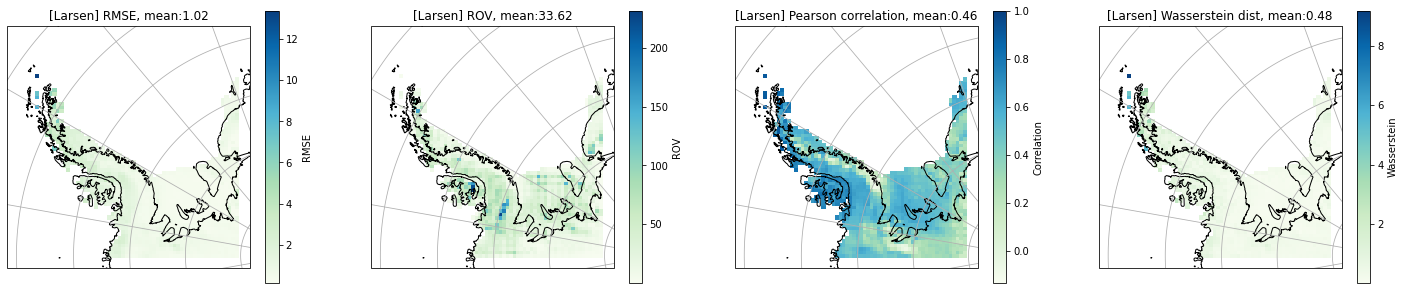

In [89]:
from metrics import *

ignoreSea = True
PearsonCorr, Wasserstein, ROV, RMSE = calculateMetrics(
    preds_Larsen, true_smb_Larsen, ignoreSea
)
plotMetrics(
    PearsonCorr,
    Wasserstein,
    ROV,
    RMSE,
    target_dataset,
    REGION,
    today,
    trainingParam["num_epochs"],
    trainingParam["batch_size"],
)


In [90]:
dataWass = metricsData(Wasserstein)
dataRMSE = metricsData(RMSE)
dataROV = metricsData(ROV)
dataCorr = metricsData(PearsonCorr)
l = [dataWass, dataRMSE, dataROV, dataCorr]
df = pd.DataFrame(l, index = ['Wasserstein', 'RMSE', 'ROV', 'Pearson'])
df

,min,p05,mean,median,p95,max
Wasserstein,0.034337,0.113146,0.482096,0.329305,1.232666,9.164146
RMSE,0.152177,0.304558,1.024574,0.681956,2.683984,13.361656
ROV,0.123406,3.093245,33.615846,27.022147,84.104387,231.476140
Pearson,-0.134802,0.172802,0.460212,0.479250,0.737912,0.926017


## Maud:

In [91]:
REGION = "Maud"
# Make target
targets, target_times = target_maker(target_dataset, region=REGION, resize=False)
# Full target to model
full_target = np.concatenate(targets, axis=0)
target_time = np.concatenate(target_times, axis=0)
target_lon = target_dataset["x"]
target_lat = target_dataset["y"]

# Make input
i1D, i2D, i1D_ns, i2D_ns, VAR_LIST = make_inputs(
    GCMLike, 
    size_input_domain=SIZE_INPUT_DOMAIN, 
    Region=REGION, 
    regionNbr=0
)
full_input = [np.concatenate([i2D], axis=0), np.concatenate([i1D], axis=0)]
full_input_ns = [
    np.concatenate([i2D_ns], axis=0),
    np.concatenate([i1D_ns], axis=0),
]

REGIONS = [REGION]

# Parameters used in training
trainingParam = dict(
    num_epochs=NUM_EPOCHS, 
    batch_size=BATCH_SIZE, 
    lr=LR,
    seed=SEED, 
    amp=AMP,
    test_percent = TEST_PERCENT,
    val_percent = VAL_PERCENT
)
# Load datasets and U-Net
train_set, test_set, net = trainFlow(
    full_input,
    full_target,
    region=REGION,
    train=False,
    **trainingParam
)
loader_args = dict(batch_size=1, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_set, shuffle=True, **loader_args)

# Load saved model
#today = str(date.today())
today = '2022-05-03'
model = f"MODEL_{today}_{REGION}_{NUM_EPOCHS}_{BATCH_SIZE}.pth"
downloadModel = True
if downloadModel:
    downloadFileFromGC(pathModel, "", model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# make predictions
preds_Maud, x_Maud, z_Maud, true_smb_Maud, r_Maud = predict(net, device, test_loader, model)

INFO: Using device cpu
INFO: Network:
	7 input channels X
	17 input channels Z
	32 size
	64 filter
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model MODEL_2022-05-03_Maud_100_32.pth
INFO: Using device cpu
INFO: Saved model loaded!


In [ ]:
# plot predictions
plotRandomPredictions(
    preds_Maud,
    x_Maud,
    z_Maud,
    true_smb_Maud,
    r_Maud,
    GCMLike,
    VAR_LIST,
    target_dataset,
    N=4,
    regions=[REGION],
    **trainingParam
)

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for mul

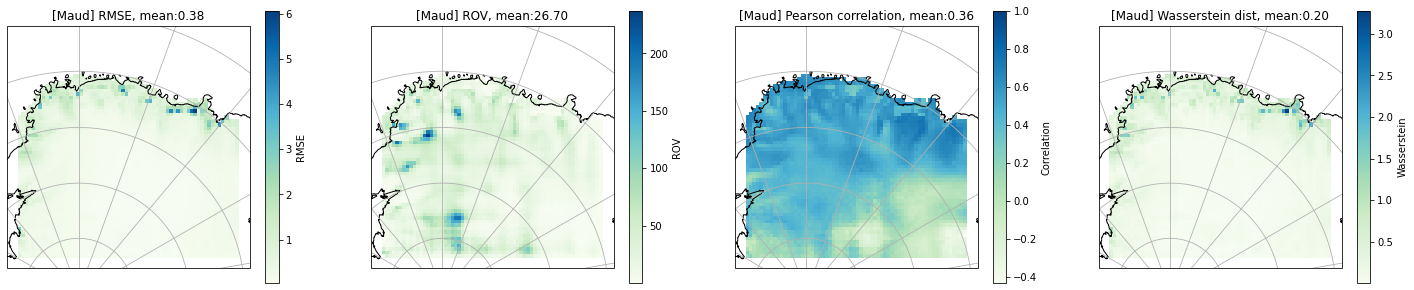

In [92]:
from metrics import *

ignoreSea = True
PearsonCorr, Wasserstein, ROV, RMSE = calculateMetrics(
    preds_Maud, true_smb_Maud, ignoreSea
)
plotMetrics(
    PearsonCorr,
    Wasserstein,
    ROV,
    RMSE,
    target_dataset,
    REGION,
    today,
    trainingParam["num_epochs"],
    trainingParam["batch_size"],
)


In [93]:
dataWass = metricsData(Wasserstein)
dataRMSE = metricsData(RMSE)
dataROV = metricsData(ROV)
dataCorr = metricsData(PearsonCorr)
l = [dataWass, dataRMSE, dataROV, dataCorr]
df = pd.DataFrame(l, index = ['Wasserstein', 'RMSE', 'ROV', 'Pearson'])
df

,min,p05,mean,median,p95,max
Wasserstein,0.009378,0.032232,0.195386,0.102541,0.676122,3.272894
RMSE,0.042750,0.065881,0.377898,0.198706,1.205748,6.058322
ROV,0.103085,2.145159,26.696457,20.478579,71.527691,236.913824
Pearson,-0.432531,-0.090394,0.355487,0.420751,0.645725,0.768527


## Wilkes:

In [94]:
REGION = "Wilkes"
# Make target
targets, target_times = target_maker(target_dataset, region=REGION, resize=False)
# Full target to model
full_target = np.concatenate(targets, axis=0)
target_time = np.concatenate(target_times, axis=0)
target_lon = target_dataset["x"]
target_lat = target_dataset["y"]

# Make input
i1D, i2D, i1D_ns, i2D_ns, VAR_LIST = make_inputs(
    GCMLike, 
    size_input_domain=SIZE_INPUT_DOMAIN, 
    Region=REGION, 
    regionNbr=0
)
full_input = [np.concatenate([i2D], axis=0), np.concatenate([i1D], axis=0)]
full_input_ns = [
    np.concatenate([i2D_ns], axis=0),
    np.concatenate([i1D_ns], axis=0),
]

REGIONS = [REGION]

# Parameters used in training
trainingParam = dict(
    num_epochs=NUM_EPOCHS, 
    batch_size=BATCH_SIZE, 
    lr=LR,
    seed=SEED, 
    amp=AMP,
    test_percent = TEST_PERCENT,
    val_percent = VAL_PERCENT
)
# Load datasets and U-Net
train_set, test_set, net = trainFlow(
    full_input,
    full_target,
    region=REGION,
    train=False,
    **trainingParam
)
loader_args = dict(batch_size=1, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_set, shuffle=True, **loader_args)

# Load saved model
#today = str(date.today())
today = '2022-05-03'
model = f"MODEL_{today}_{REGION}_{NUM_EPOCHS}_{BATCH_SIZE}.pth"
downloadModel = True
if downloadModel:
    downloadFileFromGC(pathModel, "", model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# make predictions
preds_Wilkes, x_Wilkes, z_Wilkes, true_smb_Wilkes, r_Wilkes = predict(net, device, test_loader, model)

INFO: Using device cpu
INFO: Network:
	7 input channels X
	17 input channels Z
	32 size
	64 filter
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model MODEL_2022-05-03_Wilkes_100_32.pth
INFO: Using device cpu
INFO: Saved model loaded!


In [ ]:
# plot predictions
plotRandomPredictions(
    preds_Wilkes,
    x_Wilkes,
    z_Wilkes,
    true_smb_Wilkes,
    r_Wilkes,
    GCMLike,
    VAR_LIST,
    target_dataset,
    N=4,
    regions=[REGION],
    **trainingParam
)

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for mul

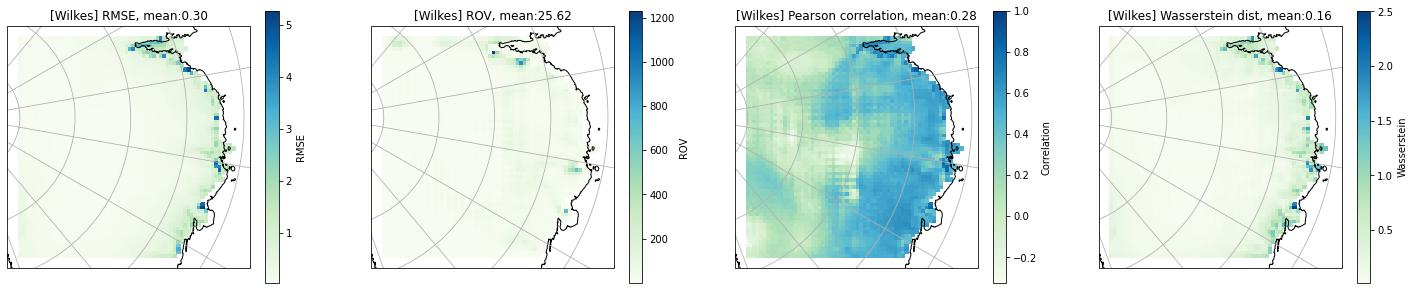

In [95]:
from metrics import *

ignoreSea = True
PearsonCorr, Wasserstein, ROV, RMSE = calculateMetrics(
    preds_Wilkes, true_smb_Wilkes, ignoreSea
)
plotMetrics(
    PearsonCorr,
    Wasserstein,
    ROV,
    RMSE,
    target_dataset,
    REGION,
    today,
    trainingParam["num_epochs"],
    trainingParam["batch_size"],
)

In [96]:
dataWass = metricsData(Wasserstein)
dataRMSE = metricsData(RMSE)
dataROV = metricsData(ROV)
dataCorr = metricsData(PearsonCorr)
l = [dataWass, dataRMSE, dataROV, dataCorr]
df = pd.DataFrame(l, index = ['Wasserstein', 'RMSE', 'ROV', 'Pearson'])
df

,min,p05,mean,median,p95,max
Wasserstein,0.016746,0.030164,0.155894,0.079131,0.590321,2.504491
RMSE,0.037897,0.052776,0.301293,0.136246,1.177972,5.262704
ROV,0.004480,0.347456,25.616645,9.226567,83.223128,1230.007935
Pearson,-0.324047,-0.060219,0.279315,0.289603,0.589812,0.845882


## Amundsen:

In [98]:
REGION = "Amundsen"
# Make target
targets, target_times = target_maker(target_dataset, region=REGION, resize=False)
# Full target to model
full_target = np.concatenate(targets, axis=0)
target_time = np.concatenate(target_times, axis=0)
target_lon = target_dataset["x"]
target_lat = target_dataset["y"]

# Make input
i1D, i2D, i1D_ns, i2D_ns, VAR_LIST = make_inputs(
    GCMLike, 
    size_input_domain=SIZE_INPUT_DOMAIN, 
    Region=REGION, 
    regionNbr=0
)
full_input = [np.concatenate([i2D], axis=0), np.concatenate([i1D], axis=0)]
full_input_ns = [
    np.concatenate([i2D_ns], axis=0),
    np.concatenate([i1D_ns], axis=0),
]

REGIONS = [REGION]

# Parameters used in training
trainingParam = dict(
    num_epochs=NUM_EPOCHS, 
    batch_size=BATCH_SIZE, 
    lr=LR,
    seed=SEED, 
    amp=AMP,
    test_percent = TEST_PERCENT,
    val_percent = VAL_PERCENT
)
# Load datasets and U-Net
train_set, test_set, net = trainFlow(
    full_input,
    full_target,
    region=REGION,
    train=False,
    **trainingParam
)
loader_args = dict(batch_size=1, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_set, shuffle=True, **loader_args)

# Load saved model
#today = str(date.today())
today = '2022-05-03'
model = f"MODEL_{today}_{REGION}_{NUM_EPOCHS}_{BATCH_SIZE}.pth"
downloadModel = True
if downloadModel:
    downloadFileFromGC(pathModel, "", model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# make predictions
preds_Am, x_Am, z_Am, true_smb_Am, r_Am = predict(net, device, test_loader, model)

INFO: Using device cpu
INFO: Network:
	7 input channels X
	17 input channels Z
	32 size
	64 filter
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model MODEL_2022-05-03_Amundsen_100_32.pth
INFO: Using device cpu
INFO: Saved model loaded!


In [ ]:
# plot predictions
plotRandomPredictions(
    preds_Am,
    x_Am,
    z_Am,
    true_smb_Am,
    r_Am,
    GCMLike,
    VAR_LIST,
    target_dataset,
    N=4,
    regions=[REGION],
    **trainingParam
)

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for mul

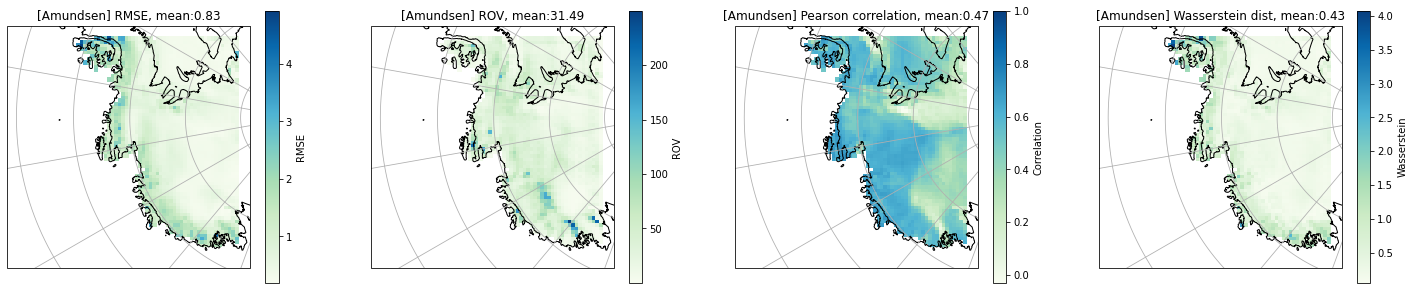

In [99]:
from metrics import *

ignoreSea = True
PearsonCorr, Wasserstein, ROV, RMSE = calculateMetrics(
    preds_Am, true_smb_Am, ignoreSea
)
plotMetrics(
    PearsonCorr,
    Wasserstein,
    ROV,
    RMSE,
    target_dataset,
    REGION,
    today,
    trainingParam["num_epochs"],
    trainingParam["batch_size"],
)

In [75]:
dataWass = metricsData(Wasserstein)
dataRMSE = metricsData(RMSE)
dataROV = metricsData(ROV)
dataCorr = metricsData(PearsonCorr)
l = [dataWass, dataRMSE, dataROV, dataCorr]
df = pd.DataFrame(l, index = ['Wasserstein', 'RMSE', 'ROV', 'Pearson'])
df

,min,p05,mean,median,p95,max
Wasserstein,0.051856,0.139888,0.432377,0.271808,1.314683,4.076607
RMSE,0.192960,0.293801,0.830736,0.577371,2.061977,4.918926
ROV,0.049499,4.748413,31.492091,25.738069,75.247821,249.712610
Pearson,-0.029529,0.170043,0.473341,0.509342,0.656066,0.732004


## Evaluation table:

In [100]:
PearsonCorr_Am, Wasserstein_Am, ROV_Am, RMSE_Am = calculateMetrics(
    preds_Am, true_smb_Am, ignoreSea
)
PearsonCorr_Wilkes, Wasserstein_Wilkes, ROV_Wilkes, RMSE_Wilkes = calculateMetrics(
    preds_Wilkes, true_smb_Wilkes, ignoreSea
)
PearsonCorr_Larsen, Wasserstein_Larsen, ROV_Larsen, RMSE_Larsen = calculateMetrics(
    preds_Larsen, true_smb_Larsen, ignoreSea
)
PearsonCorr_Maud, Wasserstein_Maud, ROV_Maud, RMSE_Maud = calculateMetrics(
    preds_Maud, true_smb_Maud, ignoreSea
)

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: 

In [121]:
dataWass = metricsData(Wasserstein_Larsen)
dataRMSE = metricsData(RMSE_Larsen)
dataROV = metricsData(ROV_Larsen)
dataCorr = metricsData(PearsonCorr_Larsen)
l = [dataWass, dataRMSE, dataROV, dataCorr]
df_Larsen = pd.DataFrame(l, index = ['Wasserstein', 'RMSE', 'ROV', 'Pearson'])
df_Larsen['Region'] = ['Larsen' for i in range(len(df_Larsen))]
df_Larsen = df_Larsen.reset_index()

In [122]:
dataWass = metricsData(Wasserstein_Wilkes)
dataRMSE = metricsData(RMSE_Wilkes)
dataROV = metricsData(ROV_Wilkes)
dataCorr = metricsData(PearsonCorr_Wilkes)
l = [dataWass, dataRMSE, dataROV, dataCorr]
df_Wilkes = pd.DataFrame(l, index = ['Wasserstein', 'RMSE', 'ROV', 'Pearson'])
df_Wilkes['Region'] = ['Wilkes' for i in range(len(df_Wilkes))]
df_Wilkes = df_Wilkes.reset_index()

In [125]:
dataWass = metricsData(Wasserstein_Am)
dataRMSE = metricsData(RMSE_Am)
dataROV = metricsData(ROV_Am)
dataCorr = metricsData(PearsonCorr_Am)
l = [dataWass, dataRMSE, dataROV, dataCorr]
df_Am = pd.DataFrame(l, index = ['Wasserstein', 'RMSE', 'ROV', 'Pearson'])
df_Am['Region'] = ['Amundsen' for i in range(len(df_Am))]
df_Am = df_Am.reset_index()

In [126]:
dataWass = metricsData(Wasserstein_Maud)
dataRMSE = metricsData(RMSE_Maud)
dataROV = metricsData(ROV_Maud)
dataCorr = metricsData(PearsonCorr_Maud)
l = [dataWass, dataRMSE, dataROV, dataCorr]
df_Maud = pd.DataFrame(l, index = ['Wasserstein', 'RMSE', 'ROV', 'Pearson'])
df_Maud['Region'] = ['Maud' for i in range(len(df_Maud))]
df_Maud = df_Maud.reset_index()

In [127]:
pd.concat([df_Larsen, df_Maud, df_Am, df_Wilkes]).groupby(['Region', 'index']).mean()

min       p05       mean     median        p95  \
Region   index                                                              
Amundsen Pearson     -0.029529  0.170043   0.473341   0.509342   0.656066   
         RMSE         0.192960  0.293801   0.830736   0.577371   2.061977   
         ROV          0.049499  4.748413  31.492091  25.738066  75.247823   
         Wasserstein  0.051856  0.139888   0.432377   0.271808   1.314683   
Larsen   Pearson     -0.134802  0.172802   0.460212   0.479250   0.737912   
         RMSE         0.152177  0.304558   1.024574   0.681956   2.683984   
         ROV          0.123406  3.093245  33.615846  27.022147  84.104387   
         Wasserstein  0.034337  0.113146   0.482096   0.329305   1.232666   
Maud     Pearson     -0.432531 -0.090394   0.355487   0.420751   0.645725   
         RMSE         0.042750  0.065881   0.377898   0.198706   1.205748   
         ROV          0.103085  2.145159  26.696457  20.478579  71.527691   
         Wasserstein  0.009378  0.032232   0.195386   0.102541   0.676122   
Wilkes   Pearson     -0.324047 -0.060219   0.279315   0.289603   0.589812   
         RMSE         0.037897  0.052776   0.301293   0.136246   1.177972   
         ROV          0.004480  0.347456  25.616645   9.226567  83.223128   
         Wasserstein  0.016746  0.030164   0.155894   0.079131   0.590321   

                              max  
Region   index                     
Amundsen Pearson         0.732004  
         RMSE            4.918926  
         ROV           249.712586  
         Wasserstein     4.076607  
Larsen   Pearson         0.926017  
         RMSE           13.361656  
         ROV           231.476140  
         Wasserstein     9.164146  
Maud     Pearson         0.768527  
         RMSE            6.058322  
         ROV           236.913824  
         Wasserstein     3.272894  
Wilkes   Pearson         0.845882  
         RMSE            5.262704  
         ROV          1230.007935  
         Wasserstein     2.504491